In [1]:
!pip install pandas_ta
!pip install pmdarima

!pip install fbprophet
!pip install pytrends

     |████████████████████████████████| 115 kB 514 kB/s            
  Preparing metadata (setup.py) ... - done
  Created wheel for pandas-ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218923 sha256=9984d629e2a5524ae00fd498eb8b1243b8105818d24621cd54d9a717ea1bb25a
  Stored in directory: /root/.cache/pip/wheels/0b/81/f0/cca85757840e4616a2c6b9fe12569d97d324c27cac60724c58
Successfully built pandas-ta
     |████████████████████████████████| 1.4 MB 513 kB/s            
  Preparing metadata (setup.py) ... - done
  Created wheel for pytrends: filename=pytrends-4.8.0-py3-none-any.whl size=16124 sha256=696c13b94f882c40ba67a680f759ea327ef6c8d6c7b28bad74e30fe288b2d0b1
  Stored in directory: /root/.cache/pip/wheels/07/6f/5c/8174f98dec1bfbc7d5da4092854afcbcff4b26c3d9b66b5183
Successfully built pytrends


In [2]:
import random 
import pandas_ta as ta
import numpy as np 
import pandas as pd 
import plotly.express as px
import seaborn as sns

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import matplotlib.ticker as ticker
import plotly.figure_factory as ff

from fbprophet import Prophet
from pandas_datareader import data
from scipy import stats
from statsmodels.tsa.seasonal import seasonal_decompose
from fbprophet.plot import plot_plotly, plot_components_plotly
from pmdarima.arima import auto_arima
from pytrends.request import TrendReq
from sklearn.preprocessing import MinMaxScaler

from matplotlib.ticker import FixedFormatter, FixedLocator

/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


# Financial Market

<img src="https://time.com/nextadvisor/wp-content/uploads/2021/09/na-what-are-cyclical-stocks.jpg" width="600px">

# Search stock data

In [3]:
def show_table(dataframe):
    colorscale = [[0, '#4d004c'],[.5, '#f2e5ff'],[1, '#ffffff']]
    fig =  ff.create_table(dataframe, colorscale=colorscale, index=True)
    for i in range(len(fig.layout.annotations)):
        fig.layout.annotations[i].font.size = 14
    fig.show()

    
def dataframe_format(df, columns):
    for column in columns:
        df[column] = df[column].round(3)
    return df

def format_index(df: dict):
    df['DateIndex'] = df.index
    df['DateIndex'] = pd.to_datetime(df['DateIndex']).dt.date
    return df

def download_dataframe(name: str, start_date: str, end_date: str):
    df = data.DataReader(name=name, data_source='yahoo', start=start_date, end=end_date)
    for column in ["High", "Low", "Open", "Close", "Adj Close"]:
        df[column] = df[column].round(3)
       # df[column] = pd.to_numeric(df[column], downcast="float")
    return df

def download_list_stocks(stocks: list, field: str, start_date: str, end_date: str):
    stocks_dataframe = pd.DataFrame()
    for stock in stocks:
        stocks_dataframe[stock] = download_dataframe(stock, start_date=start_date, end_date=end_date)[field]
    return stocks_dataframe
                                                     
def get_random_color():
    r1 = lambda: random.randint(0,255)
    return '#%02X%02X%02X' % (r1(),r1(),r1())

def save_dataframe(df: dict, file_path: str):
    df.read_csv(file_path)
    print("Success saved!")

dataframe = download_dataframe(name='PETR3.SA', start_date='2018-01-01', end_date='2022-01-01')

In [4]:
dataframe = format_index(dataframe)
show_table(dataframe.head(10))

In [5]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 989 entries, 2018-01-02 to 2021-12-30
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   High       989 non-null    float64
 1   Low        989 non-null    float64
 2   Open       989 non-null    float64
 3   Close      989 non-null    float64
 4   Volume     989 non-null    float64
 5   Adj Close  989 non-null    float64
 6   DateIndex  989 non-null    object 
dtypes: float64(6), object(1)
memory usage: 61.8+ KB


In [6]:
show_table(pd.DataFrame(dataframe.describe()))

In [7]:
show_table(dataframe[dataframe['High'] >= 21.00].head(10))

# Candlestick plot data

In [8]:
def get_candles_plot(df: dict, title: str, stock_name=''):
    fig = go.Figure(data=[go.Candlestick(x=dataframe['DateIndex'],
          open=dataframe['Open'],
          high=dataframe['High'],
          low=dataframe['Low'],
          close=dataframe['Close'])])
    fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='LightPink')
    fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='LightPink')
    fig.update_layout(title=f'{title}: {stock_name}', paper_bgcolor='white', plot_bgcolor="white", font_color="black")
    fig.show()
    
get_candles_plot(dataframe, 'Stock price', 'PETR3.SA')

In [9]:
fig = px.bar(dataframe, x='DateIndex', y='Volume')
fig.update_layout(title=f'Trading volume: PETR3.SA', barmode='stack', paper_bgcolor='white', plot_bgcolor="white", font_color="black")
fig.show()

# Moving Average

In [10]:
dataframe.ta.sma(close='Close', length=5, append=True)
dataframe.ta.sma(close='Close', length=10, append=True)
dataframe.ta.sma(close='Close', length=20, append=True)
dataframe.ta.sma(close='Close', length=200, append=True)
dataframe.ta.ema(close='Close', length=5, append=True)

Date
2018-01-02          NaN
2018-01-03          NaN
2018-01-04          NaN
2018-01-05          NaN
2018-01-08    17.708000
                ...    
2021-12-23    30.478537
2021-12-27    30.665692
2021-12-28    30.797128
2021-12-29    30.848085
2021-12-30    30.798723
Name: EMA_5, Length: 989, dtype: float64

In [11]:
dataframe = dataframe_format(dataframe, ["SMA_5", "SMA_10", "SMA_20", "SMA_200", "EMA_5"])
show_table(dataframe.head(10))

In [12]:
def get_candles_plot_avg(df: dict, title: str, stock_name='', average_fields=False):
    fig = go.Figure(data=[go.Candlestick(x=dataframe['DateIndex'],
          open=dataframe['Open'],
          high=dataframe['High'],
          low=dataframe['Low'],
          close=dataframe['Close'])])
    
    if average_fields:
        for field_avg, colors in zip(average_fields["avg_mov"],
                                     average_fields["colors"]):
            fig.add_trace(
                go.Scatter(
                    x=df.index,
                    y=df[field_avg],
                    line=dict(color=colors, width=2),
                    name=field_avg
                )
            )
    fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='LightPink')
    fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='LightPink')
    fig.update_layout(title=f'{title}: {stock_name}', width=1800, height=900, paper_bgcolor='white', plot_bgcolor="white", font_color="black")
    fig.show()
    
settings_avg = {"avg_mov": ["SMA_10", "SMA_20", "SMA_200"], "colors": ["blue", "pink", "purple"]}
get_candles_plot_avg(dataframe, 'Stock price', 'PETR3.SA', settings_avg)

In [13]:
from datetime import datetime
from datetime import timedelta

date_time_filter = '2019-01-05'
datetime_filter = dataframe[dataframe.index <= date_time_filter]
settings_avg = {"avg_mov": ["SMA_10", "SMA_20", "SMA_200"], "colors": ["blue", "pink", "purple"]}
get_candles_plot_avg(datetime_filter, 'Stock price <= 2019-01-05', 'PETR3.SA', settings_avg)

# Compare stocks list in wallet

In [14]:
stocks_list = ["VALE3.SA", "BBDC3.SA", "ITSA3.SA", "ITUB3.SA", "BBAS3.SA", 
               "PETR3.SA", "VALE3.SA", "JBSS3.SA", "OIBR3.SA", "GOLL4.SA", 
               "IRBR3.SA", "CIEL3.SA", "MGLU3.SA"]
dataframe_stocks = download_list_stocks(stocks_list, "Close", "2014-01-01", "2022-01-01")
show_table(dataframe_stocks.head(100))

In [15]:
dataframe_stocks.isnull().sum()
dataframe_stocks.dropna(inplace=True)

In [16]:
def get_stocks_histplot(df: dict, stocks: list):
    for index, stock in enumerate(stocks):
        f, (ax1) = plt.subplots(1, 1, figsize=(14, 2))
        v_dist_1 = df[f"{stock}"].values
        sns.histplot(v_dist_1, ax=ax1, color=get_random_color(), kde=True)
        ax1.set_title(f"{stock}: Close", fontsize=15)
        
        
def get_stock_histplot_central_tendency(df: dict, stocks: list):
    for index, stock in enumerate(stocks):
        f, (ax1) = plt.subplots(1, 1, figsize=(14, 5))
        v_dist_1 = df[f"{stock}"].values
        sns.histplot(v_dist_1, ax=ax1, color=get_random_color(), kde=True)
        
        mean=df[f"{stock}"].mean()
        median=df[f"{stock}"].median()
        mode=df[f"{stock}"].mode().values[0]
        
        ax1.axvline(mean, color='r', linestyle='--', label="Mean")
        ax1.axvline(median, color='g', linestyle='-', label="Mean")
        ax1.axvline(mode, color='b', linestyle='-', label="Mode")
        ax1.legend()


In [17]:
dataframe_stocks = format_index(dataframe_stocks)
show_table(dataframe_stocks.head(4))

In [18]:
def stock_plot_line(df: dict, stocks: list, title=''):
    fig = go.Figure()
    for stock in stocks:
        fig.add_trace(go.Scatter(x=df['DateIndex'], y=df[stock],
                    mode='lines',
                    name=stock))
    fig.update_layout(title=title, paper_bgcolor='white', plot_bgcolor="white", font_color="black")
    fig.show()

stock_plot_line(dataframe_stocks, stocks_list, title='Stocks price - close')

# Stocks histogram

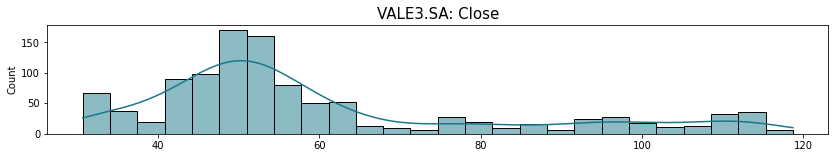

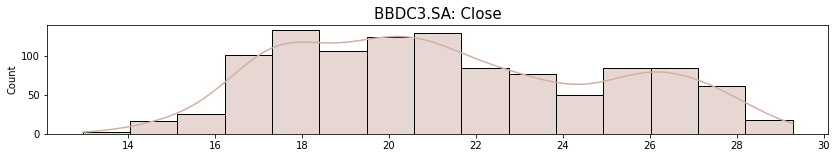

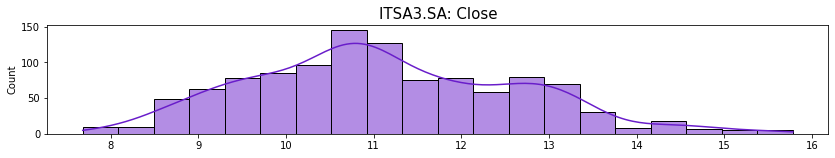

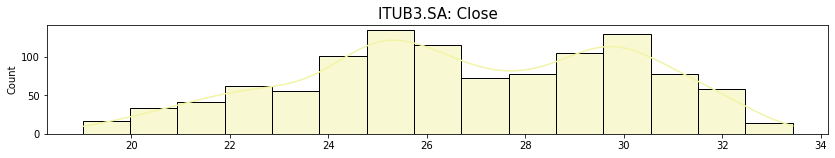

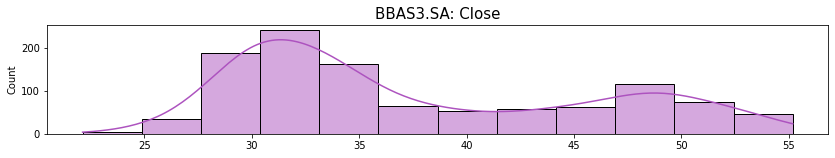

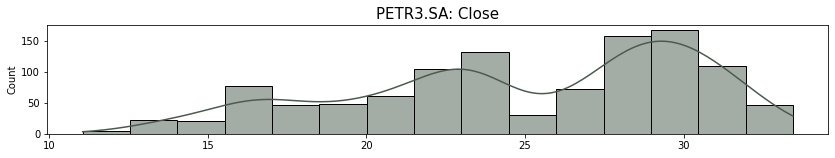

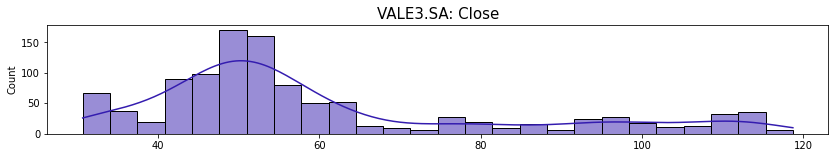

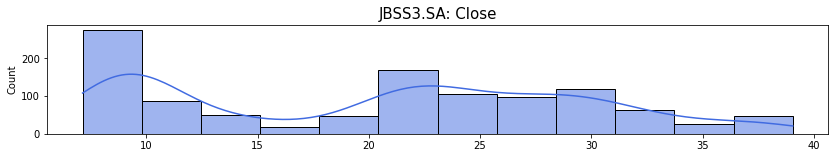

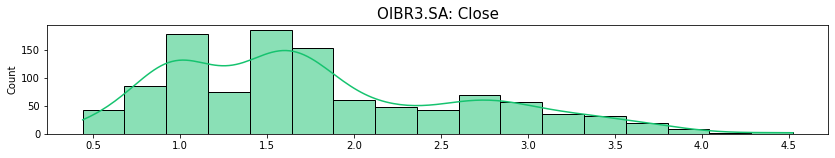

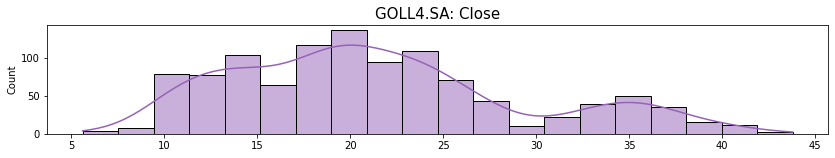

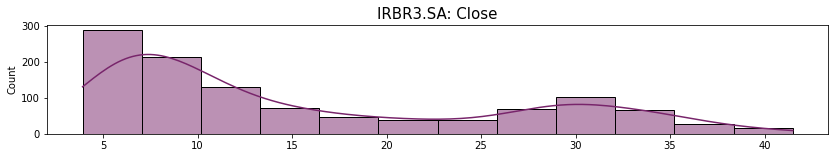

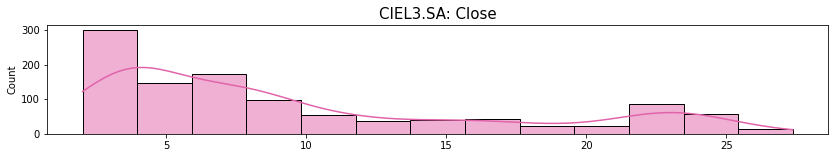

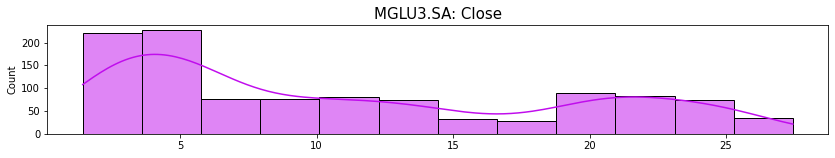

In [19]:
get_stocks_histplot(dataframe_stocks, stocks_list)

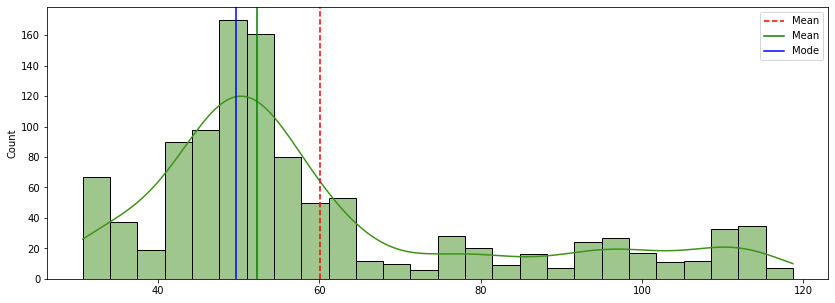

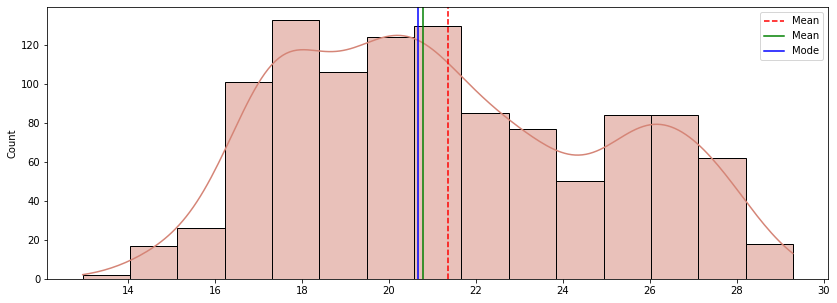

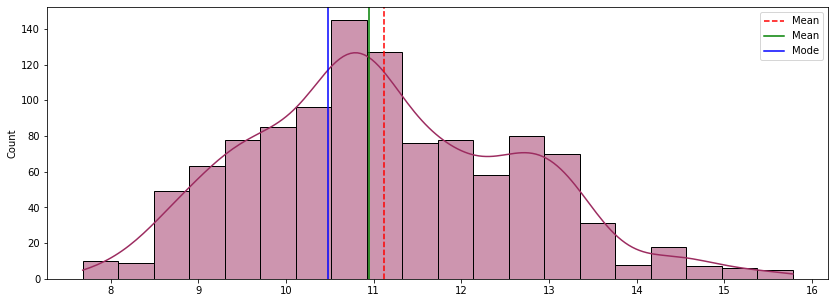

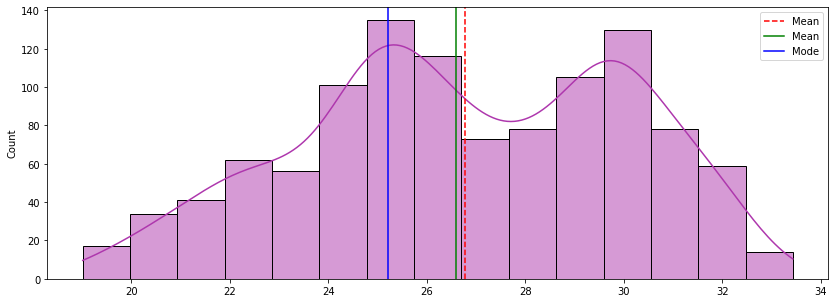

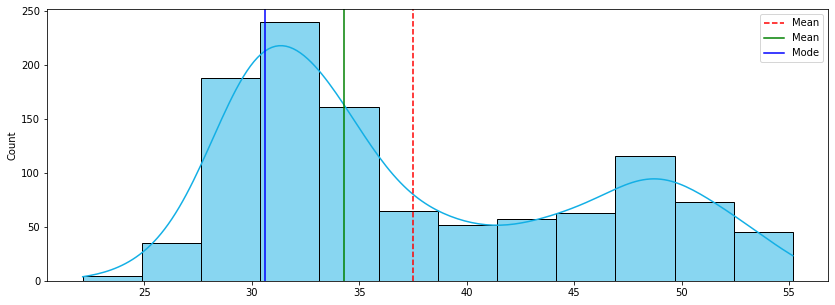

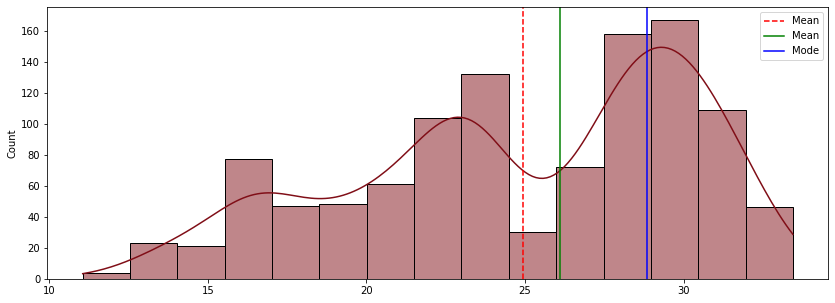

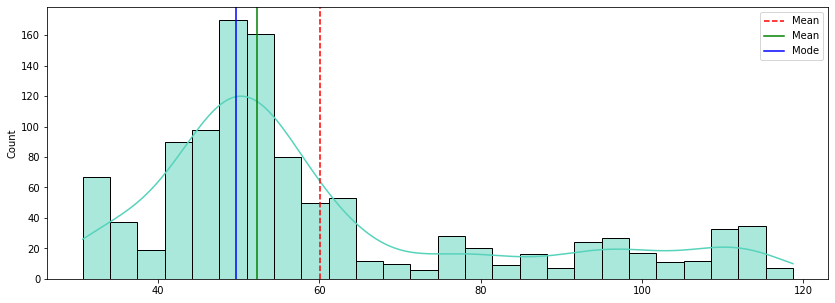

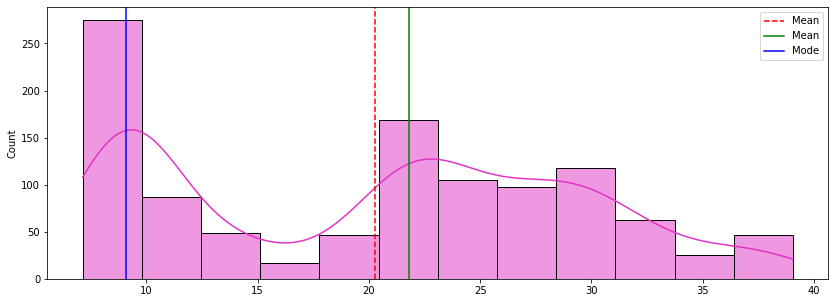

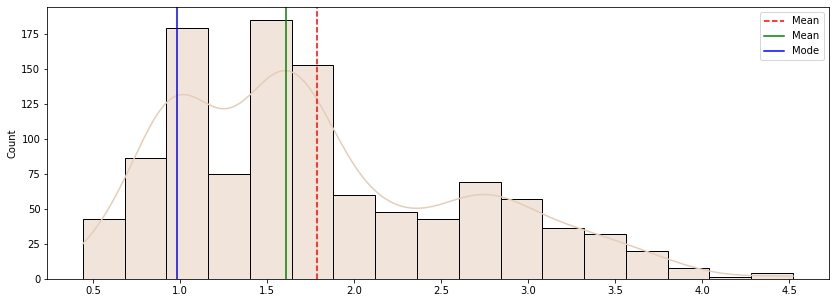

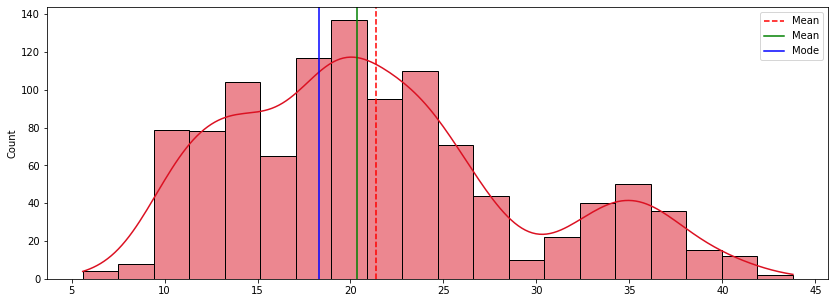

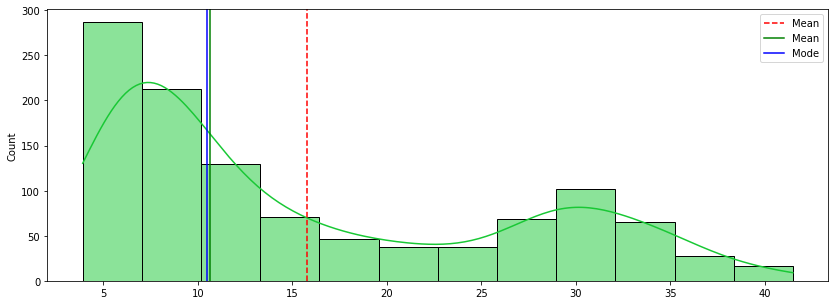

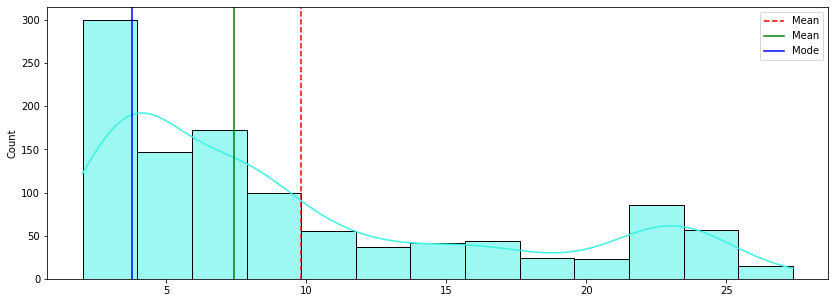

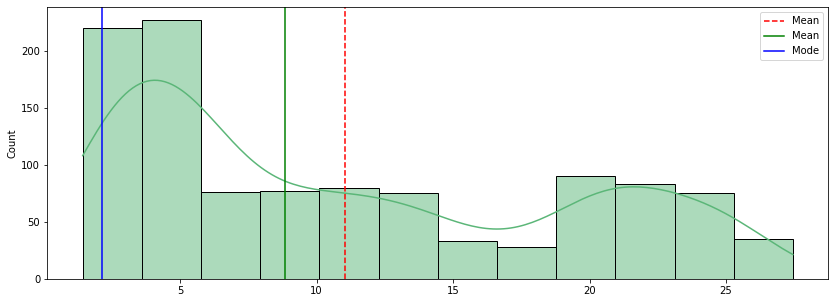

In [20]:
get_stock_histplot_central_tendency(dataframe_stocks, stocks_list)

2017         AxesSubplot(0.1,0.679412;0.363636x0.220588)
2018    AxesSubplot(0.536364,0.679412;0.363636x0.220588)
2019         AxesSubplot(0.1,0.414706;0.363636x0.220588)
2020    AxesSubplot(0.536364,0.414706;0.363636x0.220588)
2021             AxesSubplot(0.1,0.15;0.363636x0.220588)
dtype: object

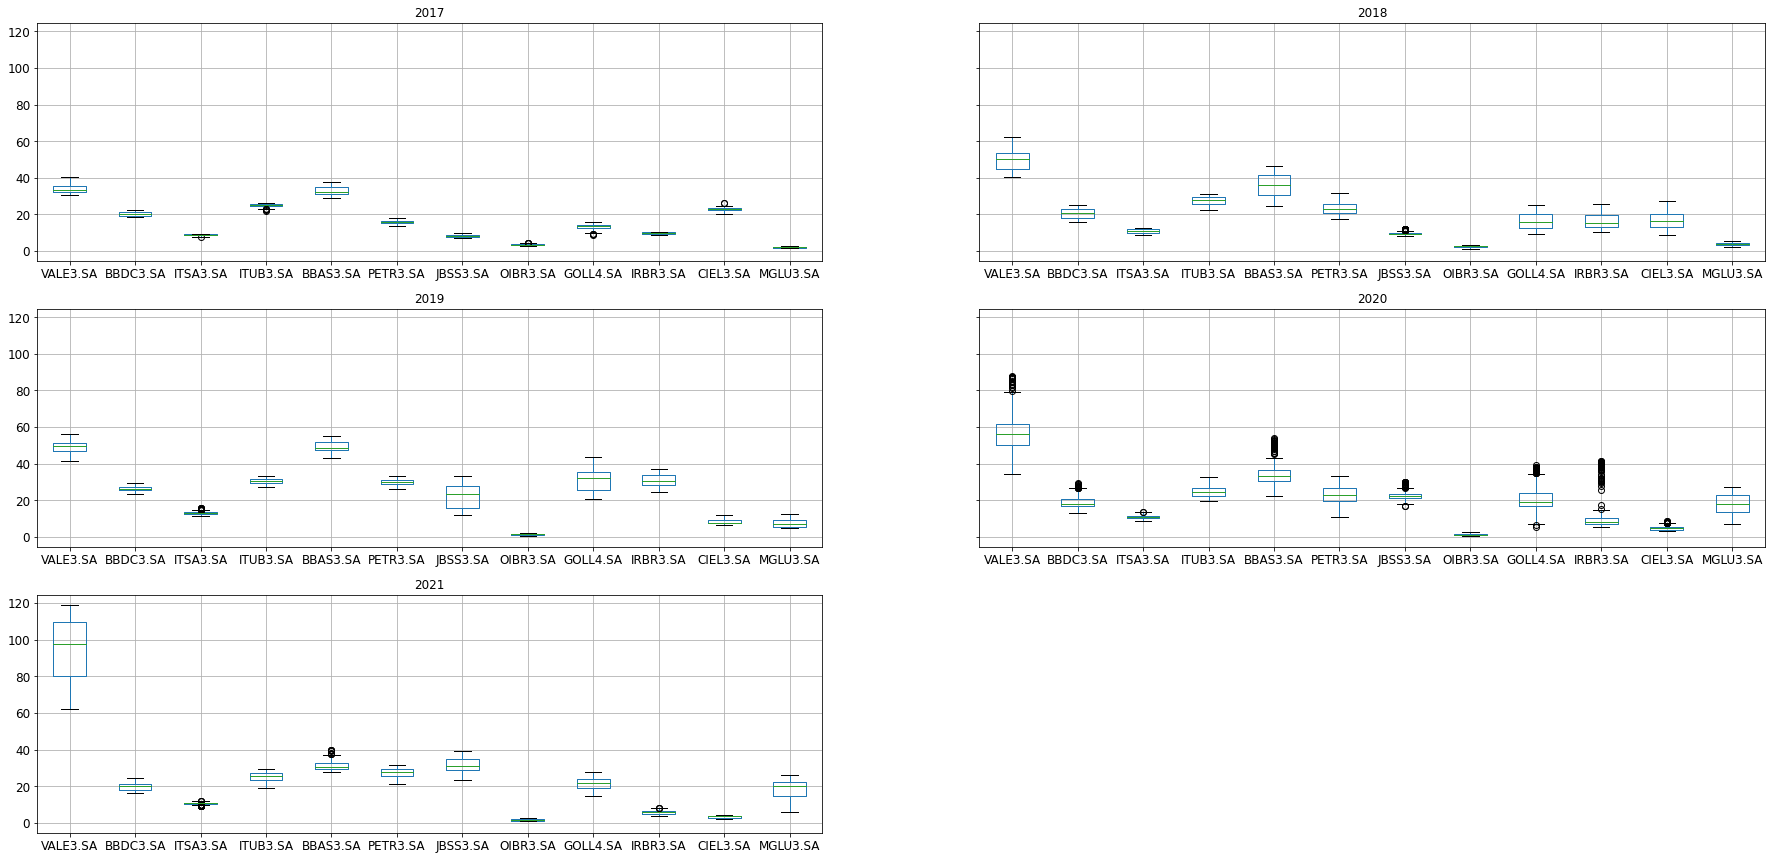

In [21]:
dataframe_stocks.groupby(dataframe_stocks.index.year).boxplot(figsize=(30, 15), fontsize=12)

In [22]:
def get_data_normalize(df: dict):
    dataframe_stocks_norm = df.copy()
    for stock in dataframe_stocks_norm.columns[:-1]:
        dataframe_stocks_norm[stock] =  round(dataframe_stocks_norm[stock] / dataframe_stocks_norm[stock][0], 3)
    return dataframe_stocks_norm

In [23]:
dataframe_stocks_norm = get_data_normalize(dataframe_stocks)
show_table(dataframe_stocks_norm.head(10))

In [24]:
stock_plot_line(dataframe_stocks_norm, stocks_list, title='Stocks price - close: normalized')

# Rate of return

In [25]:
def get_rate_return_log(df: dict, stock_name: str):
    return np.log(df[stock_name][len(df)-1] / df[stock_name][0])

def get_rate_return_daily(df: dict, stock_name: str):
    return (df[stock_name] / df[stock_name].shift(1)) - 1
    
def get_rate_return(df: dict, stock_name: str):
    Xfinal = df[stock_name][len(df) - 1]
    Xstart = df[stock_name][0]
    stock_return_rate = round(((Xfinal - Xstart) / Xstart) * 100, 1)
    return stock_return_rate

def get_all_rate_return_daily(df: dict, stock_list: list):
    df_copy = df.copy()
    for stock in stock_list:
        df_copy[f"{stock}_Rate"] = get_rate_return_daily(df_copy, stock)
    return df_copy

def get_all_rate_return_log(df: dict, stock_list: list):
    stock_name = list()
    stock_value = list()
    for stock in stock_list:
        stock_name.append(stock)
        stock_value.append(get_rate_return_log(df, stock))
    return {'stock': stock_name, 'rate': stock_value}

def get_all_rate_return(df: dict, stock_list: list):
    stock_name = list()
    stock_value = list()
    for stock in stock_list:
        stock_name.append(stock)
        stock_value.append(get_rate_return(df, stock))
    return {'stock': stock_name, 'rate': stock_value}
        

In [26]:
stock_rate_return = get_all_rate_return(dataframe_stocks, stocks_list)
stock_rate_return_log = get_all_rate_return_log(dataframe_stocks, stocks_list)
stock_rate_return_daily = get_all_rate_return_daily(dataframe_stocks, stocks_list)

stock_rate_return = pd.DataFrame.from_dict(stock_rate_return)
stock_rate_return_log = pd.DataFrame.from_dict(stock_rate_return_log)
show_table(stock_rate_return.head())

In [27]:
show_table(stock_rate_return_log.head())

In [28]:
stock_rate_return["Color"] = np.where(stock_rate_return["rate"] < 0, 'red', 'green')
stock_rate_return_log["Color"] = np.where(stock_rate_return_log["rate"] < 0, 'red', 'green')
show_table(stock_rate_return.head())

In [29]:
show_table(stock_rate_return_log.head())

In [30]:
def get_plot_rate_return(stock_rate_return: dict):
    fig = go.Figure()
    fig.add_trace(
        go.Bar(name='rate',
               x=stock_rate_return['stock'],
               y=stock_rate_return['rate'],
               marker_color=stock_rate_return['Color']))
    fig.update_layout(barmode='stack', title="Rate return in period", paper_bgcolor='white', plot_bgcolor="white", font_color="black")
    fig.show()

get_plot_rate_return(stock_rate_return)

# Wallet rate of return

In [31]:
wallet_stock_list = ["PETR3.SA", "GOLL4.SA", "CIEL3.SA"]
create_stock_wallet = download_list_stocks(wallet_stock_list, "Close", "2019-01-01", "2022-01-01")
show_table(create_stock_wallet.head(10))

In [32]:
create_stock_wallet = format_index(create_stock_wallet)
create_stock_wallet_norm = get_data_normalize(create_stock_wallet)
create_stock_wallet_norm.drop(labels=['DateIndex'], axis=1, inplace=True)
wallet_return = (create_stock_wallet_norm / create_stock_wallet_norm.shift(1)) - 1
wallet_weight = np.array([0.2, 0.4, 0.4])
show_table(create_stock_wallet.head(10))

In [33]:
stock_plot_line(create_stock_wallet, wallet_stock_list, title='Stocks price wallet - close: normalized')

In [34]:
year_return_rate = wallet_return.mean() * 246

In [35]:
def plot_indicator_return(value):
    fig = go.Figure()
    color = 'green'
    if value < 0:
        color = 'red'
    if value == 0:
        color = 'black'
    
    fig.add_trace(go.Indicator(number={'font_color': color},
        mode = "number+delta",
        value = value * 100,
        title = {"text": "Rate Wallet %"},
        domain = {'x': [0, 0.5], 'y': [0, 0.5]}))
    
    fig.show()

plot_indicator_return(np.dot(year_return_rate, wallet_weight))

# Year rate return 

In [36]:
stocks_std = dataframe_stocks.describe()

In [37]:
show_table(pd.DataFrame(stocks_std.iloc[2]))

In [38]:
def year_rate_return(df: str, start_date: str, end_date: str, stock_list: list):
    ret_value = dict()
    for stock_name in stock_list:
        xi_v = df[stock_name][df.index == start_date].tolist()
        yi_v = df[stock_name][df.index == end_date].tolist()
        if xi_v and yi_v:
            rate = round(np.log(yi_v[0] / xi_v[0]) * 100, 2)
            ret_value[stock_name] = rate
    return ret_value

In [39]:
year_rate = year_rate_return(dataframe_stocks, '2020-01-04', '2020-12-30', stocks_list)

In [40]:
filter_dates = [
            {"s": "2018-01-02", "f": "2018-12-27"},
            {"s": "2019-01-02", "f": "2019-12-27"},
            {"s": "2020-01-02", "f": "2020-12-30"},
            {"s": "2021-01-04", "f": "2021-12-30"},
]
rate_lst = []
for filter_date in filter_dates:
    xi, yi = filter_date["s"], filter_date["f"]
    rate_stocks = year_rate_return(dataframe_stocks, xi, yi, ["MGLU3.SA"])
    rate_lst.append(rate_stocks["MGLU3.SA"])
    
rate_lst = np.array(rate_lst)

# Risk analysis - using var and std

In [41]:
avg_stock = round(rate_lst.mean(), 2)
var_stock = round(rate_lst.var(), 2)
std_stock = round(rate_lst.std(), 2)

print(f'MGLU3.SA, avg:{avg_stock}, var:{var_stock}, std:{std_stock}')

MGLU3.SA, avg:24.52, var:7459.91, std:86.37


## Variance coefficient - risk

In [42]:
r_value = {}
avaliation_stocks = ["OIBR3.SA", "MGLU3.SA"]
for avaliation in avaliation_stocks:
    r_value[avaliation] = []
    
for filter_date in filter_dates:
    xi, yi = filter_date["s"], filter_date["f"]
    rate_stocks = year_rate_return(dataframe_stocks, xi, yi, avaliation_stocks)
    for stock_name in rate_stocks:
        r_value[stock_name].append(rate_stocks[stock_name])
    
df_avaliation_compare = pd.DataFrame(r_value)
show_table(df_avaliation_compare)

In [43]:
show_table(df_avaliation_compare.describe())

# Correlation

In [44]:
import math 

def get_return_rate(df: dict):
    return (df/ df.shift(1)) - 1

def get_return_rate_norm(df: dict):
    df_year = df.std() * math.sqrt(246)
    return df_year

dataframe_sample = dataframe_stocks.copy()
dataframe_sample.drop(labels = ['DateIndex'], axis=1, inplace=True)
dataframe_sample_return_rate = get_return_rate(dataframe_sample)

In [45]:
dataframe_sample_return_rate_norm = get_return_rate_norm(dataframe_sample_return_rate)
round(dataframe_sample_return_rate_norm * 100, 2)

VALE3.SA    40.25
BBDC3.SA    37.69
ITSA3.SA    27.05
ITUB3.SA    30.96
BBAS3.SA    41.58
PETR3.SA    48.43
JBSS3.SA    44.26
OIBR3.SA    65.78
GOLL4.SA    71.20
IRBR3.SA    56.89
CIEL3.SA    51.74
MGLU3.SA    56.39
dtype: float64

In [46]:
def get_headmap_stocks(df: dict, correlation_type: str):
    plt.figure(figsize=(18, 18))
    if correlation_type == "corr":
        sns.heatmap(df.corr(), annot=True, cmap='BrBG_r')
        plt.title("Correlation stock - return rate")
    if correlation_type == "cov":
        sns.heatmap(df.cov(), annot=True, cmap='BrBG_r')
        plt.title("Covariance stock - return rate")

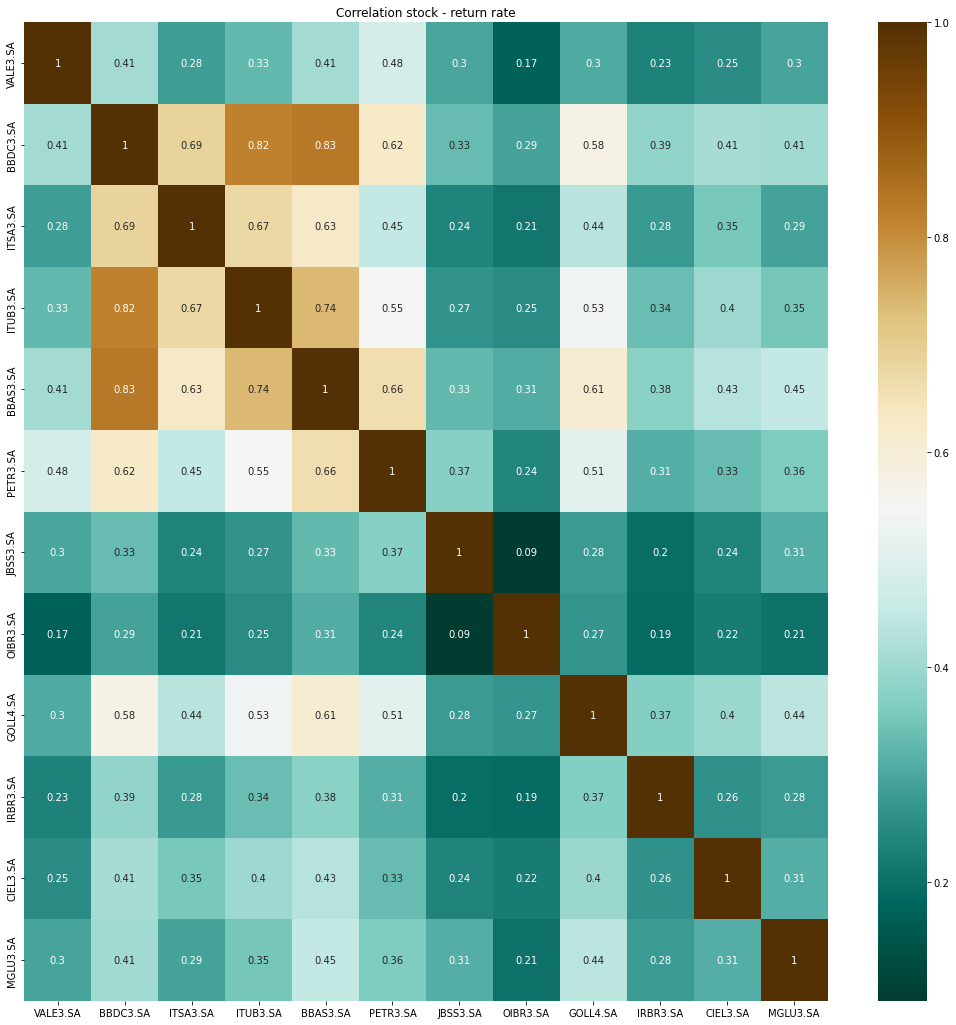

In [47]:
get_headmap_stocks(dataframe_sample_return_rate, "corr")

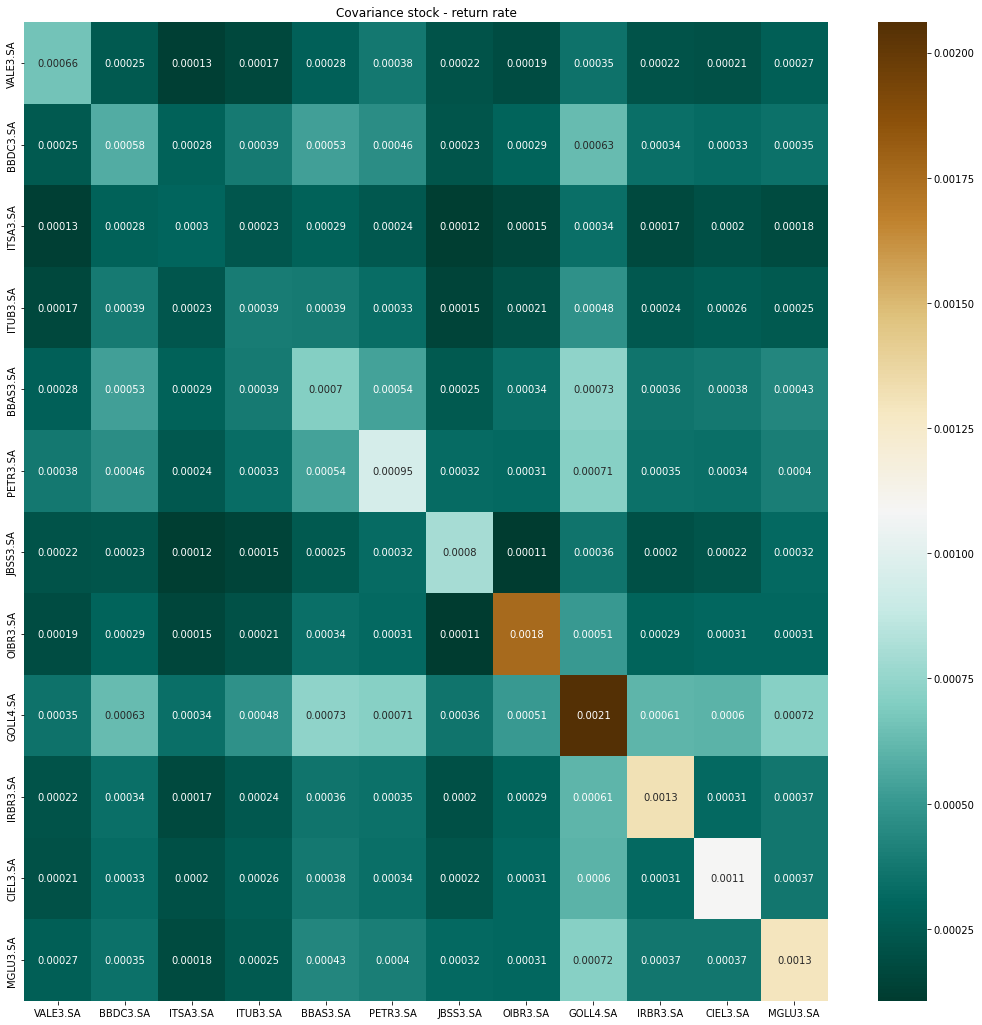

In [48]:
get_headmap_stocks(dataframe_sample_return_rate, "cov")

# Google Trends: Crypto Searchs x Prices

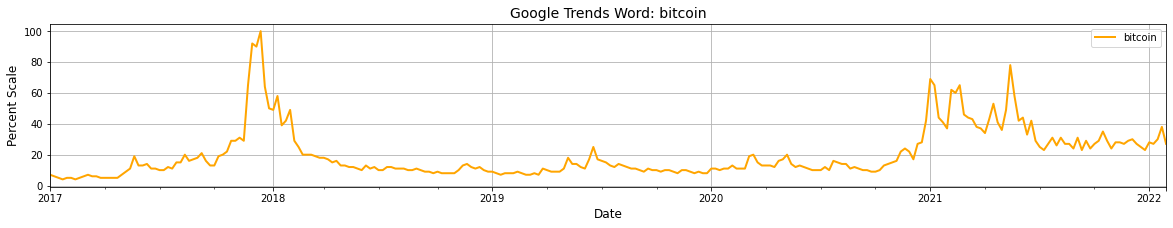

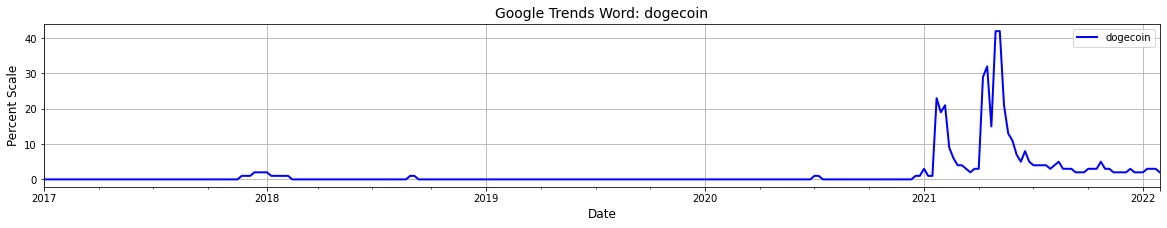

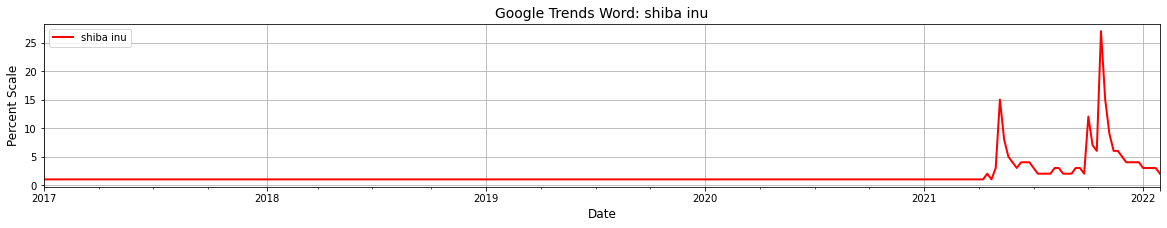

In [49]:
def search_google_trends(word: list, timeframe: str):
    google_trends = TrendReq()
    google_trends.build_payload(word, timeframe=timeframe)
    return google_trends.interest_over_time()

def plot_trend(df: dict, word: str, color: list):
    plt.figure(figsize=(20, 3))
    df[word].plot(lw=2, color=color)
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Percent Scale", fontsize=12)
    plt.title(f"Google Trends Word: {word}", fontsize=14)
    plt.legend()
    plt.grid()


timeframe='2017-01-01 2022-02-01'
word_list = ["bitcoin", "dogecoin", "shiba inu"]
color_list = ["orange", "blue", "red"]
dataframe_trends = search_google_trends(word_list, timeframe=timeframe)
for word, color in zip(word_list, color_list):
    plot_trend(dataframe_trends, word, color)

In [50]:
show_table(dataframe_trends.head(10))

In [51]:
list_crypto = ["BTC-USD", "DOGE-USD", "SHIB-USD"]
start_date, end_date = timeframe.split(" ")
dataframe_stock_total = download_list_stocks(list_crypto, "High", start_date, end_date)
dataframe_stock_total = dataframe_stock_total.fillna(0)
dataframe_stock_total["DateIndex"] = pd.to_datetime(dataframe_stock_total.index, unit='s')
show_table(dataframe_stock_total.head(10))

In [52]:
def preprocessor_min_max(df: dict, field: str):
    min_max = MinMaxScaler()
    scaled = min_max.fit_transform(df[field].values.reshape(-1, 1))
    df["MinMax"] = scaled * 100
    return df

def preprocessor_min_max_all(df: dict, field_list: list):
    min_max = MinMaxScaler()
    for field in field_list:
        scaled = min_max.fit_transform(df[field].values.reshape(-1, 1))
        df[f"MinMax_{field}"] = scaled * 100
    return df
    
    
dataframe_stock_total = preprocessor_min_max_all(dataframe_stock_total, list_crypto)
show_table(dataframe_stock_total.head(10))

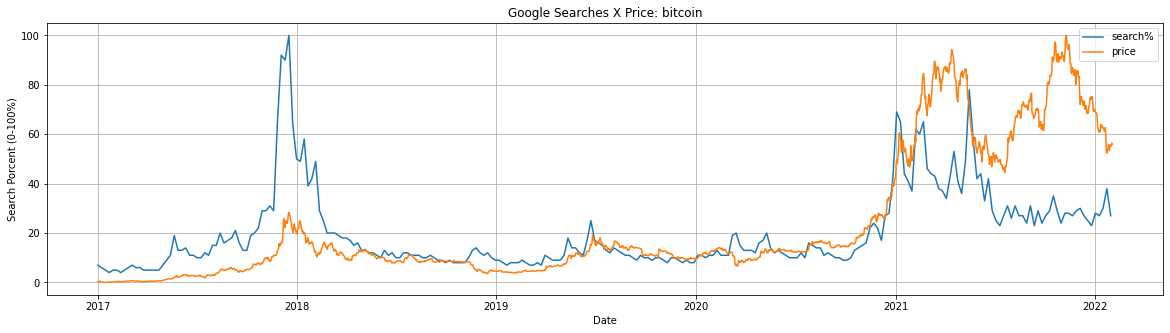

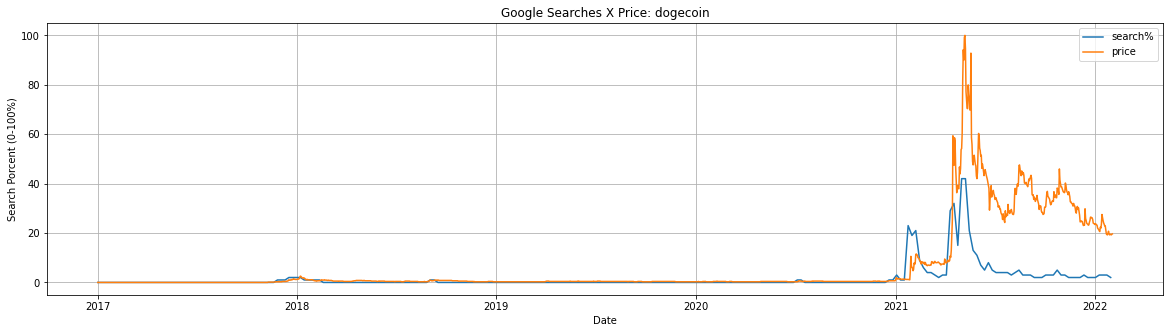

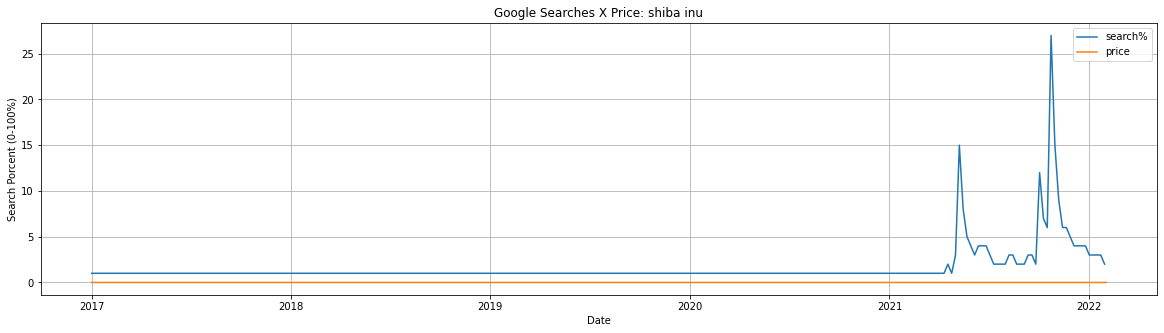

In [53]:
def plot_compare_trends_price(df_trends: dict, df_stocks: dict, word: str):
    fig, ax = plt.subplots(figsize=(20, 5))
    ax.set_title(f"Google Searches X Price: {word}")
    ax.set_xlabel("Date")
    ax.set_ylabel("Search Porcent (0-100%)")
    ax.plot(df_trends.index, df_trends[word], alpha=1, label="search%")
    ax.plot(df_stocks["DateIndex"], df_stocks["MinMax"], alpha=1, label="price")
    plt.legend()
    plt.grid()

def plot_compare_trends_price_all(df_trends: dict, df_stocks: dict, words: list, list_stock: list):
    for word, stock in zip(words, list_stock):
        fig, ax = plt.subplots(figsize=(20, 5))
        ax.set_title(f"Google Searches X Price: {word}")
        ax.set_xlabel("Date")
        ax.set_ylabel("Search Porcent (0-100%)")
        ax.plot(df_trends.index, df_trends[word], alpha=1, label="search%")
        ax.plot(df_stocks["DateIndex"], df_stocks[f"MinMax_{stock}"], alpha=1, label="price")
        plt.legend()
        plt.grid()

plot_compare_trends_price_all(dataframe_trends, dataframe_stock_total, word_list, list_crypto)

# Monte Carlo Simulation

<img src="https://miro.medium.com/max/1400/1*YcTh0gKplFrZTIZRaBgjJQ.png">

"Monte Carlo methods, or Monte Carlo experiments, are a broad class of computational algorithms that rely on repeated random sampling to obtain numerical results. The underlying concept is to use randomness to solve problems that might be deterministic in principle. They are often used in physical and mathematical problems and are most useful when it is difficult or impossible to use other approaches. Monte Carlo methods are mainly used in three problem classes: optimization, numerical integration, and generating draws from a probability distribution."

https://en.wikipedia.org/wiki/Monte_Carlo_method

In [54]:
dataframe_simulation = download_dataframe(name='PETR3.SA', start_date='2014-01-01', end_date='2018-02-02')
dataframe_simulation_norm = get_data_normalize(dataframe_simulation)
dataframe_simulation = dataframe_simulation['Close']
dataframe_simulation_norm = dataframe_simulation_norm['Close']
dataframe_simulation_norm.head(10)

Date
2014-01-02    1.000
2014-01-03    0.980
2014-01-06    0.992
2014-01-07    0.961
2014-01-08    0.961
2014-01-09    0.936
2014-01-10    0.949
2014-01-13    0.930
2014-01-14    0.926
2014-01-15    0.956
Name: Close, dtype: float64

In [55]:
dataframe_simulation_rt = np.log(1 + dataframe_simulation_norm.pct_change())
dataframe_simulation_rt.fillna(0, inplace=True)
dataframe_simulation_rt

Date
2014-01-02    0.000000
2014-01-03   -0.020203
2014-01-06    0.012171
2014-01-07   -0.031749
2014-01-08    0.000000
                ...   
2018-01-29    0.000000
2018-01-30   -0.024346
2018-01-31    0.005214
2018-02-01    0.038620
2018-02-02   -0.026803
Name: Close, Length: 1021, dtype: float64

In [56]:
drift = dataframe_simulation_rt.mean() - (0.5 * dataframe_simulation_rt.var())
print(f"Drift: {drift}")

Drift: -0.0002495686568786187


<AxesSubplot:ylabel='Count'>

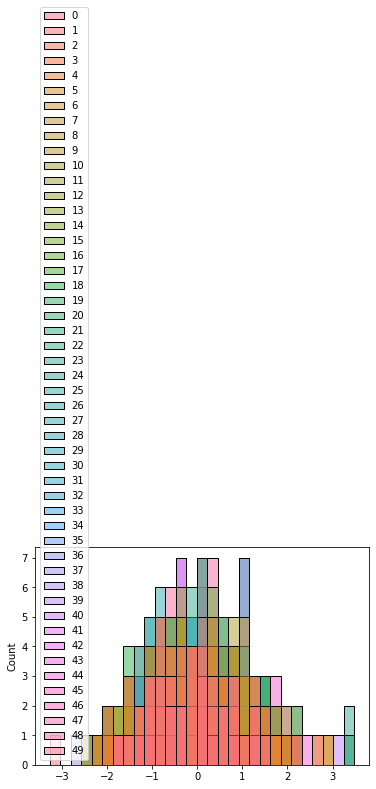

In [57]:
days_prev_len = 30
simulations = 50
Z = stats.norm.ppf(np.random.rand(days_prev_len, simulations))
sns.histplot(Z)

In [58]:
def get_plot_pred(predictions: list):
    fig = px.line(title = 'Simulations')
    for i in range(len(predictions.T)):
        fig.add_scatter(y = predictions.T[i], name = i)
    fig.update_layout(paper_bgcolor='white', plot_bgcolor="white", font_color="black")
    fig.show()

df_std = dataframe_simulation_rt.std()
days_rt = np.exp(drift + df_std * Z)
days_pred = np.zeros_like(days_rt)
days_pred[0] = dataframe_simulation.iloc[-1]

for i in range(1, days_prev_len):
    days_pred[i] = days_pred[i - 1] * days_rt[i]
get_plot_pred(days_pred)

In [59]:
dataframe_stock_new = download_dataframe(name='PETR3.SA', start_date='2018-02-03', end_date='2018-12-20')
dataframe_stock_new = dataframe_stock_new['Close']

s = days_pred.T[0][0:len(dataframe_stock_new)]

In [60]:
from sklearn.metrics import mean_absolute_error

dataframe_stock_new = dataframe_stock_new[0:days_prev_len]
mean_absolute_error(dataframe_stock_new, s)

sqerror = list()
for i in range(len(days_pred.T)):
    sqerror.append(mean_absolute_error(dataframe_stock_new, days_pred.T[i][0:days_prev_len]))

In [61]:
def plot_best_predict(df: dict, index_max: int, index_min: int):
    fig = px.line(title='Predict Simulation - Monte Carlo', markers=True)
    fig.add_scatter(y=df, name='value')
    fig.add_scatter(y=days_pred.T[index_max], name='biggest pred error')
    fig.add_scatter(y=days_pred.T[index_min], name='smallest pred error')
    fig.update_traces(mode='markers+lines')
    fig.update_layout(paper_bgcolor='white', plot_bgcolor="white", font_color="black")
    fig.show()

index_min = np.argmin(sqerror)
index_max = np.argmax(sqerror)
plot_best_predict(dataframe_stock_new, index_max, index_min)

# Times Series Predict: ARIMA

In [62]:
times_series = download_dataframe(name='PETR3.SA', start_date='2007-01-01', end_date='2020-02-02')
times_series_v2 = times_series.copy()

In [63]:
times_series.dropna(inplace=True)
times_series = times_series['Close']
len(times_series)

3244

In [64]:
percent = int(len(times_series) * 0.90)
times_series_train = times_series[:percent]
times_series_test = times_series[percent:]

print(f'Train: {len(times_series_train)}, Test: {len(times_series_test)}')

print(f'Train > First_date: {times_series_train.index.min()} - Final_date: {times_series_train.index.max()}')
print(f'Test > First_date: {times_series_test.index.min()} - Final_date: {times_series_test.index.max()}')
 

Train: 2919, Test: 325
Train > First_date: 2007-01-02 00:00:00 - Final_date: 2018-10-04 00:00:00
Test > First_date: 2018-10-05 00:00:00 - Final_date: 2020-01-31 00:00:00


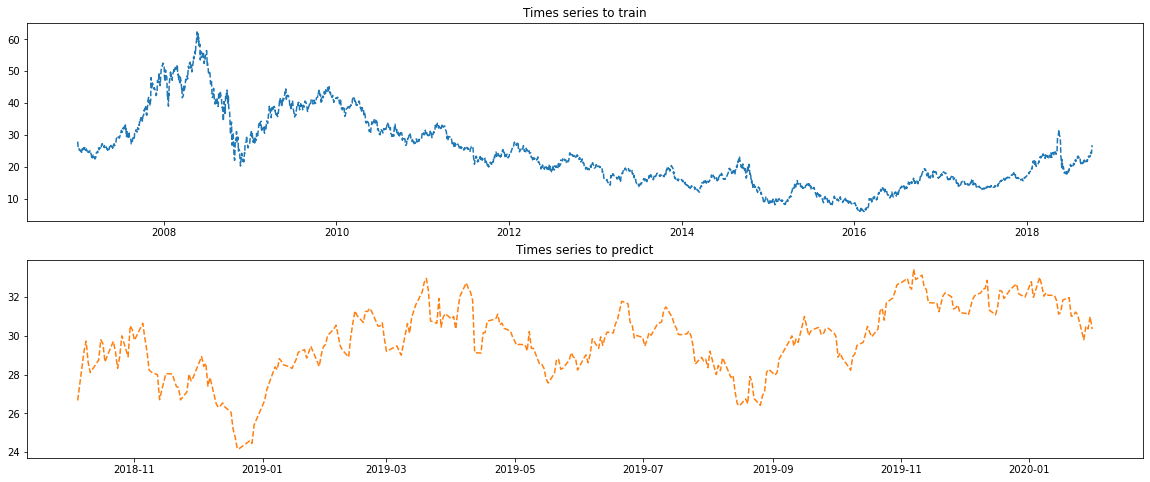

In [65]:
def plot_line(df_1: dict, df_2: dict):
    fig = plt.figure(figsize=(20, 8))
    plt.subplot(211)
    plt.title("Times series to train")
    plt.plot(df_1, color='tab:blue', linestyle='--')

    plt.subplot(212)
    plt.title("Times series to predict")
    plt.plot(df_2, color='tab:orange', linestyle='--')
    plt.show()


def plot_line_tedency(df: dict):

    fig = plt.figure(figsize=(20, 8))
    plt.subplot(211)
    plt.title("Times series - trend")
    plt.plot(df.trend, color='tab:blue', linestyle='--')

    plt.subplot(212)
    plt.title("Times series - resid")
    plt.plot(df.resid, color='tab:orange', linestyle='--')


times_series.head(10)
plot_line(times_series_train, times_series_test)

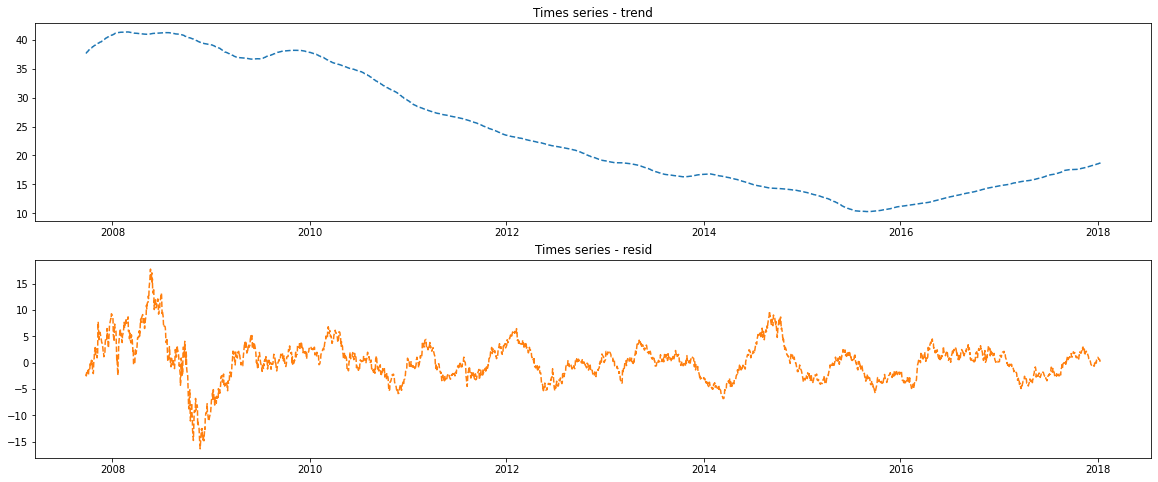

In [66]:
times_series_stats = seasonal_decompose(times_series_train, period=365)
plot_line_tedency(times_series_stats)

In [67]:
def build_model(times_series_train: dict):
    return auto_arima(times_series_train, suppress_warnings=True, error_action='ignore')


def model_predict(model, period):
    return model.predict(n_periods=period)

In [68]:
model = build_model(times_series_train)
pred = model_predict(model, len(times_series_test))
pred = pd.DataFrame(pred, columns=['pred_value'], index=times_series_test.index)
show_table(pred.head(20))

In [69]:
def plot_arima_pred(train: dict, test: dict, pred: dict):
    plt.figure(figsize=(20, 4))
    config = {'name': ['train', 'test', 'predict'],
              'color': ['green', 'orange', 'red'],
              'data': [train, test, pred]}
              
    for i in range(3):
        plt.plot(config['data'][i], label=config['name'][i], color=config['color'][i])
    plt.legend()

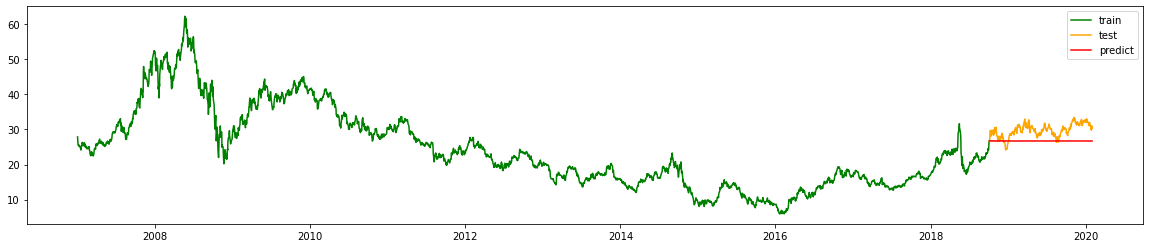

In [70]:
plot_arima_pred(times_series_train, times_series_test, pred)

In [71]:
print(f'Absolute error: {mean_absolute_error(times_series_test, pred)}')

Absolute error: 3.1835096552422293


# Times Series Predict: Prophet

In [72]:
times_series_v2 = format_index(times_series_v2)
times_series_v2.reset_index(drop=True, inplace=True)
times_series_v2 = times_series_v2[["DateIndex", "Close"]]
times_series_v2 = times_series_v2[["DateIndex", "Close"]].rename(columns={'Close': 'y', 'DateIndex': 'ds'})
times_series_train_v2 = times_series_v2.iloc[:percent, [0, 1]]
times_series_test_v2 = times_series_v2.iloc[percent:, [0, 1]]

In [73]:
print(f"Train: {len(times_series_train_v2)} Test: {len(times_series_test_v2)}")
model_prophet = Prophet()
model_prophet.fit(times_series_train_v2)

Train: 2919 Test: 325


Initial log joint probability = -50.8748
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       6154.72     0.0359155       1133.37           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       6395.95     0.0163975       500.458           1           1      240   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       6547.91      0.182229       1399.93           1           1      348   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       6618.48    0.00469747       315.337           1           1      453   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       6656.21     0.0316761       257.642           1           1      562   
    Iter      log prob        ||dx||      ||grad||       alpha  

In [74]:
pred_prophet = model_prophet.predict(model_prophet.make_future_dataframe(periods=len(times_series_test_v2)))
predict = pred_prophet['yhat'].tail(len(times_series_test_v2))
error = mean_absolute_error(times_series_test_v2['y'], predict)
print(f"Mean absolute error: {error}")

Mean absolute error: 3.948514256847775


In [75]:
plot_plotly(model_prophet, pred_prophet)